In [1]:
import numpy as np
import rasterio
from rasterio.windows import Window

import cv2 
import geopandas as gpd

from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import cascaded_union
from collections import defaultdict

from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

In [2]:
# creating polygons from pixel masks
# from https://www.kaggle.com/lopuhin/full-pipeline-demo-poly-pixels-ml-poly

def mask_to_polygons(mask, epsilon=10, min_area=50.):
    # first, find contours with cv2: it's much faster than shapely
    image, contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
#     epsi = lambda x: epsilon*cv2.arcLength(x,True)
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

In [3]:
INPUT = Path('znz-20190118')

# grid_042
COG_URL  = 'https://oin-hotosm.s3.amazonaws.com/5ae318220b093000130afd64/0/5ae318220b093000130afd65.tif'

## If needed, reproject to EPSG:4326

In [4]:
src_tif = 'grid_042_20190118_test1x_merged.tif'
dst_tif = 'grid_042_20190118_test1x_merged_reproj.tif'

In [5]:
raster = rasterio.open(INPUT/src_tif,'r')
raster.meta

{'count': 3,
 'crs': CRS({'init': 'epsg:32737'}),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 40592,
 'nodata': None,
 'transform': Affine(0.07398361590021522, 0.0, 534722.5625,
       0.0, -0.07398361590021522, 9347193.0),
 'width': 40551}

In [ ]:
# https://rasterio.readthedocs.io/en/latest/topics/reproject.html

from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'

with rasterio.open(INPUT/src_tif) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height,
        'compress': 'JPEG',
        'tiled': True, 
        'blockxsize': 256, 
        'blockysize': 256
    })

    with rasterio.open(INPUT/dst_tif, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest,
            )

or with gdalwarp on CLI:

In [ ]:
!gdalwarp -co compress=JPEG -co PHOTOMETRIC=YCBCR -co TILED=YES -co "BLOCKXSIZE=256" -co "BLOCKYSIZE=256" -s_srs EPSG:32737 -t_srs EPSG:4326 {INPUT}/{src_tif} {INPUT}/{dst_tif}   

## Open and Read Windows

In [11]:
dst_tif = 'grid_042_20190118_test1x_merged_reproj.tif'

In [12]:
raster = rasterio.open(INPUT/dst_tif,'r')
data = raster.read()

In [13]:
raster.meta

{'count': 3,
 'crs': CRS({'init': 'epsg:4326'}),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 40642,
 'nodata': None,
 'transform': Affine(6.688361704925057e-07, 0.0, 39.31369530504978,
       0.0, -6.688361704925057e-07, -5.905835679072139),
 'width': 40549}

In [14]:
raster.block_shapes

[(256, 256), (256, 256), (256, 256)]

In [15]:
def pad_window(window, pad):
    col_off, row_off, width, height = window.flatten()
    return Window(col_off-pad//2, row_off-pad//2,width+pad,height+pad)

In [16]:
# padded windowed reads with blocks and rasterio: https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html

pad = 64
windows = []
for ji, window in raster.block_windows(1):
    assert len(set(raster.block_shapes)) == 1
    window_padded = pad_window(window, pad)
    windows.append((ji, window_padded))

In [17]:
len(windows)

25281

In [18]:
windows[150:160]

[((0, 150), Window(col_off=38368, row_off=-32, width=320, height=320)),
 ((0, 151), Window(col_off=38624, row_off=-32, width=320, height=320)),
 ((0, 152), Window(col_off=38880, row_off=-32, width=320, height=320)),
 ((0, 153), Window(col_off=39136, row_off=-32, width=320, height=320)),
 ((0, 154), Window(col_off=39392, row_off=-32, width=320, height=320)),
 ((0, 155), Window(col_off=39648, row_off=-32, width=320, height=320)),
 ((0, 156), Window(col_off=39904, row_off=-32, width=320, height=320)),
 ((0, 157), Window(col_off=40160, row_off=-32, width=320, height=320)),
 ((0, 158), Window(col_off=40416, row_off=-32, width=165, height=320)),
 ((1, 0), Window(col_off=-32, row_off=224, width=320, height=320))]

In [19]:
def poly2coords(poly_mask, transform):
    geo_coords = [(coord[0],coord[1])*transform for coord in poly[0].exterior.coords for poly in poly_mask]
    return Polygon(geo_coords)

In [20]:
mask_thres = 0.7
epsilon = 10
min_area = 100.
erode = 5
dilate = 7

polys = []

for window in tqdm(windows):
    win_tnfm = rasterio.windows.transform(window[1], raster.meta['transform'])
    win_img = raster.read(window=window[1])[0,:,:]

    mask = win_img > (mask_thres*255)
    # erode and dilate
    mask = cv2.erode(mask.astype('uint8'), np.ones((erode,erode),np.uint8), iterations=1)
    mask = cv2.dilate(mask.astype('uint8'), np.ones((dilate,dilate),np.uint8), iterations=1)

    # label via connected components
    _, instances = cv2.connectedComponents(mask.astype('uint8'))

    # make polys from instances
    uniques = list(np.unique(instances))
    for b in uniques[1:]:
        poly = mask_to_polygons(instances==b,epsilon, min_area)
        try: 
            if poly.type == 'MultiPolygon': 
                geo_coords = poly2coords(poly, win_tnfm)
                polys.append(geo_coords)
            #else: print('not a MultiPolygon')
        except Exception as exc: print(f"{exc}: {window}")

100%|██████████| 25281/25281 [01:36<00:00, 261.01it/s]


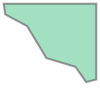

In [21]:
polys[5]

In [22]:
len(polys)

1374

In [23]:
# dedupe windowed polys
merged_poly = gpd.GeoDataFrame()
merged_poly['geometry'] = gpd.GeoSeries(cascaded_union(polys))

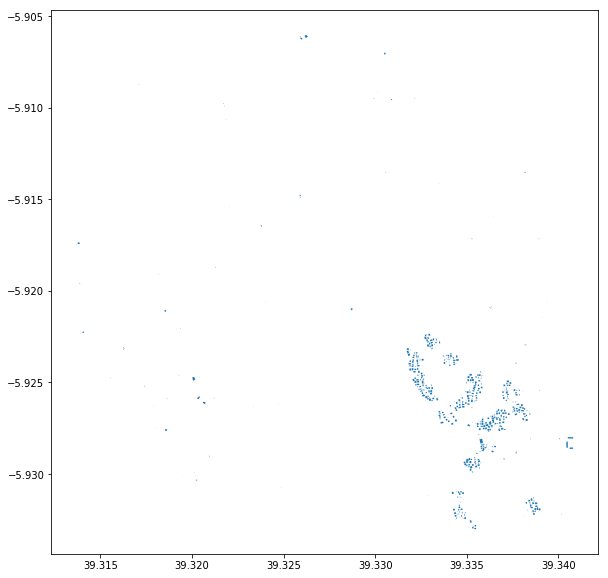

In [24]:
merged_poly['geometry'].plot(figsize=(10,10))

In [25]:
# https://gis.stackexchange.com/questions/271733/geopandas-dissolve-overlapping-polygons
# https://nbviewer.jupyter.org/gist/rutgerhofste/6e7c6569616c2550568b9ce9cb4716a3

def explode(gdf):
    """    
    Will explode the geodataframe's muti-part geometries into single 
    geometries. Each row containing a multi-part geometry will be split into
    multiple rows with single geometries, thereby increasing the vertical size
    of the geodataframe. The index of the input geodataframe is no longer
    unique and is replaced with a multi-index. 

    The output geodataframe has an index based on two columns (multi-index) 
    i.e. 'level_0' (index of input geodataframe) and 'level_1' which is a new
    zero-based index for each single part geometry per multi-part geometry
    
    Args:
        gdf (gpd.GeoDataFrame) : input geodataframe with multi-geometries
        
    Returns:
        gdf (gpd.GeoDataFrame) : exploded geodataframe with each single 
                                 geometry as a separate entry in the 
                                 geodataframe. The GeoDataFrame has a multi-
                                 index set to columns level_0 and level_1
        
    """
    gs = gdf.explode()
    gdf2 = gs.reset_index().rename(columns={0: 'geometry'})
    gdf_out = gdf2.merge(gdf.drop('geometry', axis=1), left_on='level_0', right_index=True)
    gdf_out = gdf_out.set_index(['level_0', 'level_1']).set_geometry('geometry')
    gdf_out.crs = gdf.crs
    return gdf_out

In [26]:
gdf_out = explode(merged_poly)
gdf_out = gdf_out.reset_index()

In [27]:
gdf_out.tail(10)

,level_0,level_1,geometry
544,0,544,POLYGON ((39.33511716149397 -5.925905446040107...
545,0,545,POLYGON ((39.33723098105324 -5.925858627508173...
546,0,546,POLYGON ((39.33303202757488 -5.925865315869879...
547,0,547,POLYGON ((39.33340657583036 -5.925973561723787...
548,0,548,"POLYGON ((39.33285077297268 -5.92592943188898,..."
549,0,549,POLYGON ((39.33319321709197 -5.925913755822831...
550,0,550,POLYGON ((39.32121636778696 -5.925847257293275...
551,0,551,POLYGON ((39.33477635230753 -5.925879564334813...
552,0,552,POLYGON ((39.33483520989054 -5.925875348412435...
553,0,553,POLYGON ((39.33279956369665 -5.925849118792386...


In [28]:
# fill holes
gdf_out.geometry = gdf_out.geometry.apply(lambda x: Polygon([coords for coords in x.exterior.coords]))

In [29]:
gdf_out.drop(columns=['level_0','level_1'], inplace=True)

In [30]:
gdf_out.head(10)

,geometry
0,POLYGON ((39.33541910386737 -5.933005141989885...
1,POLYGON ((39.33544093278592 -5.932788954015309...
2,POLYGON ((39.33536813942263 -5.932867853017452...
3,"POLYGON ((39.33511650327424 -5.93288484702722,..."
4,POLYGON ((39.33529715149344 -5.932885891116247...
5,POLYGON ((39.33547644485371 -5.932902942118994...
6,POLYGON ((39.33439177150949 -5.932479369876262...
7,POLYGON ((39.33442540360594 -5.932361270968963...
8,POLYGON ((39.33483320338203 -5.932416566159852...
9,POLYGON ((39.33490543768843 -5.932354692504306...


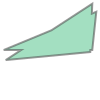

In [31]:
gdf_out.iloc[5].geometry

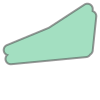

In [32]:
gdf_out.iloc[5].geometry.buffer(0.000002, cap_style=1, join_style=1)

In [33]:
# buffer polys
gdf_out['geometry_buffered'] = gdf_out.geometry.buffer(0.000002, cap_style=1, join_style=1)

In [34]:
~raster.meta['transform']

Affine(1495134.4501354313, 0.0, -58779260.21270748,
       0.0, -1495134.4501354313, -8830018.380619733)

In [35]:
gdf_out['coords_pixel'] = gdf_out.geometry_buffered.apply(lambda x: Polygon([np.round(coords*~raster.meta['transform']) for coords in x.exterior.coords]))

In [36]:
gdf_out['coords_geo_rounded'] = gdf_out.geometry_buffered.apply(lambda x: Polygon([np.round(coords,6) for coords in x.exterior.coords]))

In [37]:
gdf_out.head()

,geometry,geometry_buffered,coords_pixel,coords_geo_rounded
0,POLYGON ((39.33541910386737 -5.933005141989885...,POLYGON ((39.33541308434184 -5.933007141989886...,"POLYGON ((32471 40625, 32471 40625, 32470 4062...","POLYGON ((39.335413 -5.933007, 39.335413 -5.93..."
1,POLYGON ((39.33544093278592 -5.932788954015309...,POLYGON ((39.33543994125422 -5.932787098088375...,"POLYGON ((32511 40296, 32520 40287, 32520 4028...","POLYGON ((39.33544 -5.932787, 39.335446 -5.932..."
2,POLYGON ((39.33536813942263 -5.932867853017452...,POLYGON ((39.33536607110349 -5.932866080282638...,"POLYGON ((32401 40414, 32399 40369, 32399 4036...","POLYGON ((39.335366 -5.932866, 39.335365 -5.93..."
3,"POLYGON ((39.33511650327424 -5.93288484702722,...",POLYGON ((39.33511558848227 -5.932883043772769...,"POLYGON ((32026 40439, 32030 40437, 32031 4043...","POLYGON ((39.335116 -5.932883, 39.335118 -5.93..."
4,POLYGON ((39.33529715149344 -5.932885891116247...,POLYGON ((39.33529523898535 -5.932884091309337...,"POLYGON ((32295 40441, 32295 40437, 32295 4043...","POLYGON ((39.335295 -5.932884, 39.335295 -5.93..."


In [38]:
gdf_out.geometry = gdf_out.geometry_buffered

In [39]:
gdf_out.geometry.to_file(f'znz-20190118/grid_042_20190118_07.geojson', driver='GeoJSON')

# Crop detected building images for classifier

In [40]:
cog_rst = rasterio.open(COG_URL,'r')

In [41]:
cog_rst.meta

{'count': 3,
 'crs': CRS({'init': 'epsg:32737'}),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 40592,
 'nodata': None,
 'transform': Affine(0.07398000359535217, 0.0, 534722.5625,
       0.0, -0.07398000359535217, 9347193.0),
 'width': 40551}

In [43]:
df = gpd.read_file(f'znz-20190118/grid_042_20190118_07.geojson')
df.tail()

,id,geometry
549,549,POLYGON ((39.33319121709197 -5.925916336254251...
550,550,POLYGON ((39.32118186754836 -5.925845296098843...
551,551,POLYGON ((39.33473255063748 -5.925809365537983...
552,552,POLYGON ((39.33483495121217 -5.925877331613258...
553,553,POLYGON ((39.33280527643467 -5.925849097958112...


In [44]:
cog_rst.meta['crs']['init']

'epsg:32737'

In [45]:
from pyproj import Proj, transform

condition = 'test'
grid_num = '042'
CLASSIFY = Path('znz-20190118-classify')
CLASSIFY.mkdir(exist_ok=True)
(CLASSIFY/f'{condition}_{grid_num}').mkdir(exist_ok=True)

for i,row in tqdm(df[(df['geometry'].type=='Polygon')].iterrows()):
    
    poly = row['geometry'].buffer(0.00001) # padding around detection to crop
#     print(poly.bounds)

    inProj = Proj(init='epsg:4326') 
    outProj = Proj(init=cog_rst.meta['crs']['init']) # convert to cog crs
    
    # convert from geocoords to display window
    minx, miny = transform(inProj,outProj,*poly.bounds[:2])
    maxx, maxy = transform(inProj,outProj,*poly.bounds[2:])
    ul = cog_rst.index(minx, miny)
    lr = cog_rst.index(maxx, maxy)
    disp_minx, disp_maxx, disp_miny, disp_maxy = lr[0], (max(ul[0],0)+1), max(ul[1],0), (lr[1]+1)

    if disp_maxx-disp_minx <= 150: disp_maxx += 25; disp_minx-=25; 
    if disp_maxy-disp_miny <= 150: disp_maxy += 25; disp_miny-=25;

    window = (max(disp_minx,0), disp_maxx), (max(disp_miny,0), disp_maxy)
    data = cog_rst.read(window=window)
    
    pk = str(row.id).zfill(5)
    tile_bgr = cv2.cvtColor(np.rollaxis(data,0,3), cv2.COLOR_RGB2BGR)
    cv2.imwrite(f"{str(CLASSIFY)}/{condition}_{grid_num}/{grid_num}_{pk}_{condition}.jpg", tile_bgr)


554it [00:40, 13.58it/s]


# Update Preds with Classifer Results

In [46]:
import pandas as pd

In [47]:
df = gpd.read_file(f'znz-20190118/grid_042_20190118_07.geojson')
df.tail()

,id,geometry
549,549,POLYGON ((39.33319121709197 -5.925916336254251...
550,550,POLYGON ((39.32118186754836 -5.925845296098843...
551,551,POLYGON ((39.33473255063748 -5.925809365537983...
552,552,POLYGON ((39.33483495121217 -5.925877331613258...
553,553,POLYGON ((39.33280527643467 -5.925849097958112...


In [48]:
preds = pd.read_csv('znz-20190118/20190118_042_preds01.csv')

In [49]:
preds.tail()

,Complete,Incomplete,Foundation,Empty,fname,predicted_class
549,0.386892,0.605134,0.007770,0.000204,042_00549_test.jpg,Incomplete
550,0.989759,0.008848,0.001385,0.000008,042_00550_test.jpg,Complete
551,0.860170,0.136741,0.003020,0.000069,042_00551_test.jpg,Complete
552,0.892912,0.098531,0.006926,0.001631,042_00552_test.jpg,Complete
553,0.976437,0.021409,0.001920,0.000234,042_00553_test.jpg,Complete


In [50]:
df['conf_foundation'] = preds['Foundation']
df['conf_completed'] = preds['Complete']
df['conf_unfinished'] = preds['Incomplete']

In [51]:
df.tail()

,id,geometry,conf_foundation,conf_completed,conf_unfinished
549,549,POLYGON ((39.33319121709197 -5.925916336254251...,0.007770,0.386892,0.605134
550,550,POLYGON ((39.32118186754836 -5.925845296098843...,0.001385,0.989759,0.008848
551,551,POLYGON ((39.33473255063748 -5.925809365537983...,0.003020,0.860170,0.136741
552,552,POLYGON ((39.33483495121217 -5.925877331613258...,0.006926,0.892912,0.098531
553,553,POLYGON ((39.33280527643467 -5.925849097958112...,0.001920,0.976437,0.021409


In [61]:
df_noempty = df[(df[['conf_foundation','conf_unfinished', 'conf_completed']] > 0.5).any(axis=1)]

In [69]:
df.shape, df_noempty.shape

((554, 5), (524, 5))

In [63]:
from shapely import wkt

def create_geojson(df, save_path):
    newgpd = gpd.GeoDataFrame()
    newgpd.geometry = df['geometry']#.apply(wkt.loads)
    newgpd['cat'] = df[['conf_foundation', 'conf_unfinished','conf_completed']].idxmax(axis=1)
    newgpd['building_id'] = df['id']
    newgpd['conf_foundation'] = np.round(df['conf_foundation'],4)
    newgpd['conf_completed'] = np.round(df['conf_completed'],4)
    newgpd['conf_unfinished'] = np.round(df['conf_unfinished'],4)
    newgpd.to_file(f'{save_path}.geojson', driver='GeoJSON')
    
    return newgpd

In [65]:
create_geojson(df_noempty, 'znz-20190118/grid_042_20190118_07_classes')

,geometry,cat,building_id,conf_foundation,conf_completed,conf_unfinished
0,POLYGON ((39.33541308434184 -5.933007141989886...,conf_completed,0,0.0049,0.9765,0.0185
1,POLYGON ((39.33543994125422 -5.932787098088375...,conf_completed,1,0.0096,0.6228,0.3669
2,POLYGON ((39.33536607110349 -5.932866080282638...,conf_completed,2,0.0062,0.9525,0.0408
3,POLYGON ((39.33511558848227 -5.932883043772769...,conf_completed,3,0.0189,0.9730,0.0079
4,POLYGON ((39.33529523898535 -5.932884091309337...,conf_foundation,4,0.8673,0.0280,0.1034
5,"POLYGON ((39.335459885366 -5.932911374447694, ...",conf_completed,5,0.0099,0.9259,0.0628
6,POLYGON ((39.33438984916733 -5.932477552135353...,conf_completed,6,0.0319,0.8994,0.0680
7,POLYGON ((39.33442321596969 -5.932359678070838...,conf_foundation,7,0.9799,0.0026,0.0174
8,POLYGON ((39.33483331857509 -5.932414569479969...,conf_completed,8,0.0260,0.9409,0.0330
9,"POLYGON ((39.3348661602123 -5.932396651226719,...",conf_foundation,9,0.9872,0.0003,0.0123
